<a href="https://colab.research.google.com/github/ravidkrisi/FINAL_PROJECT/blob/master/Final_Project_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# introduction

# Data Preprocessing

In [ ]:
# data preprocess
import librosa
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# visualize
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
# link with google drive to fetch data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


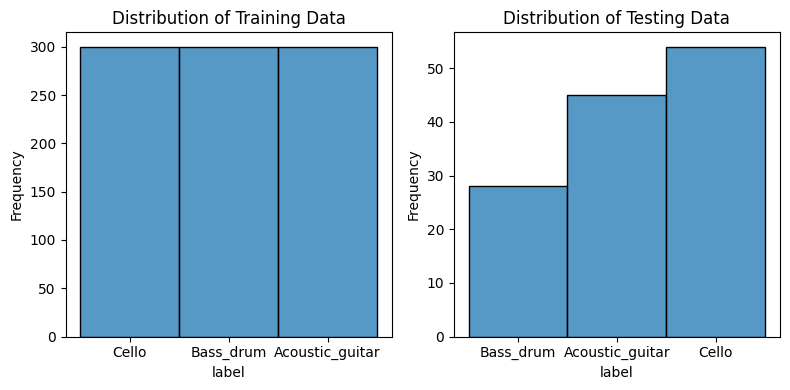

In [ ]:
# loading data
df_train = pd.read_csv("/content/drive/MyDrive/datasets/musical_instruments_classification/metadata/train2_metadata.csv")
df_train.shape
df_test = pd.read_csv("/content/drive/MyDrive/datasets/musical_instruments_classification/metadata/test2_metadata.csv")
df_train.shape

# Create a figure and axis object with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plotting the distribution for training data
sns.histplot(df_train['label'], ax=axs[0])
axs[0].set_xlabel('label')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Training Data')

# Plotting the distribution for testing data
sns.histplot(df_test['label'], ax=axs[1])
axs[1].set_xlabel('label')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Testing Data')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### extract MFCC

In [ ]:
sr = 16000
# Define a function to compute MFCC features for a given audio file
def compute_mfcc(file_path):
    # Load audio file
    audio, _ = librosa.load(file_path)  # Change sr as needed

    # Compute MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # Change n_mfcc as needed
    return mfccs

# Define a function to compute MFCC features for a given audio file, padding zeros to match max_file shape
def compute_mfcc_padding(file_path, max_shape):
    # Load audio file
    audio, sr = librosa.load(file_path)  # Change sr as needed

    # Compute MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # Change n_mfcc as needed

    # Pad MFCC array to match max_shape
    padded_mfccs = np.pad(mfccs, ((0, 0), (0, max_shape[1] - mfccs.shape[1])), mode='constant')
    return padded_mfccs

# find the largest file
def find_largest_file(directory):
  largest_file = None
  largest_size = 0

  # Iterate over all files in the directory
  for filename in os.listdir(directory):
      filepath = os.path.join(directory, filename)
      # Check if it's a file (not a directory)
      if os.path.isfile(filepath):
          # Get the size of the file
          size = os.path.getsize(filepath)
          # Update largest_file and largest_size if necessary
          if size > largest_size:
              largest_size = size
              largest_file = filepath

  return largest_file

In [ ]:
# extract largest file mfcc shape
directory = "/content/drive/MyDrive/datasets/musical_instruments_classification/train"
max_file_name = find_largest_file(directory)
max_file_path = os.path.join(directory, max_file_name)
max_shape = compute_mfcc(max_file_path).shape
max_shape

(13, 1288)

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []

# process the train data to MFCC feature
for index, row in df_train.iterrows():
    file_path = os.path.join(directory, row['fname'])
    mfcc = compute_mfcc_padding(file_path, max_shape)
    X_train.append(mfcc)
    y_train.append(row['label'])

# process the test data to MFCC feature
for index, row in df_test.iterrows():
    file_path = os.path.join(directory, row['fname'])
    mfcc = compute_mfcc_padding(file_path, max_shape)
    X_test.append(mfcc)
    y_test.append(row['label'])

# Convert lists to numpy arrays
X_train = np.array(X_train)
# y_train = np.array(y_train)
X_test = np.array(X_test)
# y_test = np.array(y_test)

# Convert string labels to one-hot encoded vectors
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

# Create a dictionary to map labels to their one-hot encodings
y_dict = {label: encoding for label, encoding in zip(label_binarizer.classes_, label_binarizer.transform(label_binarizer.classes_))}

# Reshape the input data to flatten the MFCC features
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_train_flat = np.ravel(y_train)

# Transform one-hot encoded labels to shape of (n_samples,)
y_train_flat = np.argmax(y_train, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

In [ ]:
# Transform one-hot encoded labels to shape of (n_samples,)
y_train_flat = np.argmax(y_train, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

In [ ]:
def visualize_mfcc(df, indices, xs, sr=22050):
    num_plots = len(indices)
    plt.figure(figsize=(7 * num_plots, 3))

    for i, (index, x) in enumerate(zip(indices, xs), 1):
        plt.subplot(1, num_plots, i)
        librosa.display.specshow(x, x_axis="time", sr=sr)
        plt.colorbar(format="%+2.f")
        plt.title(df.at[index, 'label'])

    plt.tight_layout()
    plt.show()

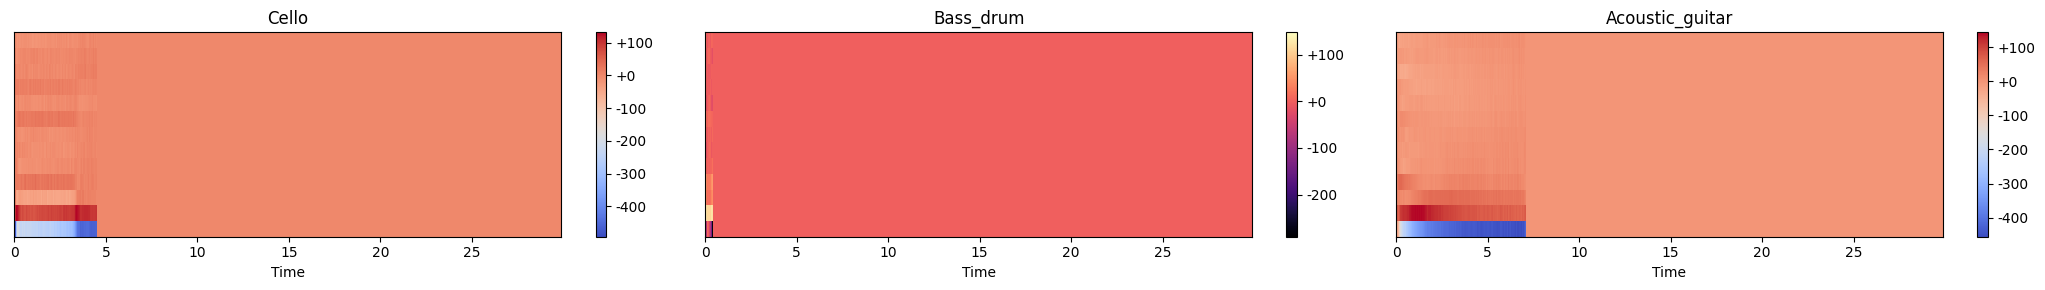

In [ ]:
# # show the MFCC of cello and bass drum
index_of_cello = df_train.index[df_train['label'] == 'Cello'].tolist()[0]
index_of_bass_drum = df_train.index[df_train['label'] == 'Bass_drum'].tolist()[0]
index_of_acustic_guitar = df_train.index[df_train['label'] == 'Acoustic_guitar'].tolist()[0]

indices = [index_of_cello, index_of_bass_drum, index_of_acustic_guitar]
x_list = [X_train[index_of_cello], X_train[index_of_bass_drum], X_train[index_of_acustic_guitar]]

visualize_mfcc(df_train, indices, x_list)

### data normalization

In [ ]:
# Normalize the training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Logistic Regression

Logistic regression is a statistical method used for binary classification tasks, predicting the probability that an instance belongs to a particular class. It works by modeling the relationship between the independent variables and the probability of the binary outcome using the logistic function. During training, it optimizes the parameters to minimize the difference between predicted probabilities and actual class labels, typically using techniques like maximum likelihood estimation or gradient descent

In [ ]:
# Initialize a logistic regression classifier with increased max_iter
logistic_regression = LogisticRegression(max_iter=1000)

# Train the logistic regression classifier on the training data
logistic_regression.fit(X_train_scaled, y_train_flat)

# Predict labels for the test data
y_pred_logistic = logistic_regression.predict(X_test_scaled)

# Calculate accuracy
accuracy_logistic = accuracy_score(y_test_flat, y_pred_logistic)
print("Accuracy Logistic Regression:", accuracy_logistic)

Accuracy Logistic Regression: 0.889763779527559


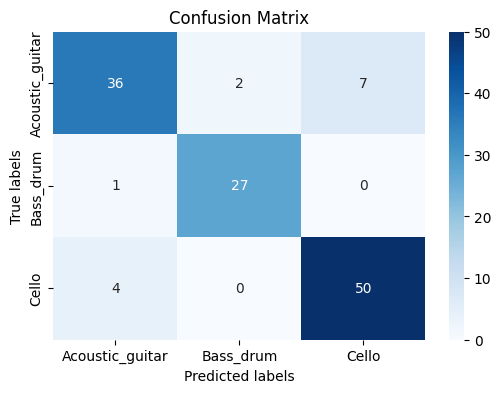

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_logistic)

# Get class names from y_dict
class_names = [key for key in y_dict.keys()]

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## SVM (SVC)

Support Vector Machine (SVM) is a versatile algorithm used for classification and regression tasks. It excels in finding hyperplanes that separate classes in feature space, maximizing the margin for generalization.Support Vector Classifier (SVC). SVC allows for kernel selection and parameter tuning, offering flexibility for optimal model performance.

In [ ]:
# Instantiate SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier
svm_classifier.fit(X_train_scaled, y_train_flat)

# Make predictions
y_pred = svm_classifier.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test_flat, y_pred)
print("Accuracy of SVM classifier:", accuracy)

Accuracy of SVM classifier: 0.9133858267716536


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_logistic)

# Get class names from y_dict
class_names = [key for key in y_dict.keys()]

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## KNN

K-Nearest Neighbors (KNN) is a simple yet effective supervised machine learning algorithm used for classification and regression tasks.
* **K Parameter**: The 'k' in KNN represents the number of nearest neighbors to consider. It's a hyperparameter that needs to be specified before training. Choosing the right 'k' value is crucial, as it can affect the algorithm's performance and its ability to generalize well on unseen data.

* **Distance Metric**: Typically, Euclidean distance is used to measure the distance between data points in the feature space, but other distance metrics like Manhattan distance or Minkowski distance can also be used depending on the problem and data characteristics.



In [ ]:
# Define K values and metrics
K_values = [1, 3, 5, 7, 9]
metrics = ['euclidean', 'manhattan', 'chebyshev']
num_metrics = len(metrics)


# Initialize arrays to store train error and test error for each metric and K value
train_errors = np.zeros((num_metrics, len(K_values)))
test_errors = np.zeros((num_metrics, len(K_values)))

# Transform one-hot encoded labels to shape of (n_samples,)
y_train_knn = np.argmax(y_train, axis=1)
y_test_knn = np.argmax(y_test, axis=1)


# Train Decision Tree classifiers for each metric and K value
for i, metric in enumerate(metrics):
    for j, k in enumerate(K_values):
        # Define KNN classifier with current metric and K value
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)

        # Fit KNN classifier on the normalized training data
        knn.fit(X_train_scaled, y_train_knn)

        # Predict labels for the normalized training data
        y_train_pred = knn.predict(X_train_scaled)

        # Calculate train error
        train_error = 1 - accuracy_score(y_train_knn, y_train_pred)
        train_errors[i, j] = train_error

        # Predict labels for the normalized test data
        y_test_pred = knn.predict(X_test_scaled)

        # Calculate test error
        test_error = 1 - accuracy_score(y_test_knn, y_test_pred)
        test_errors[i, j] = test_error

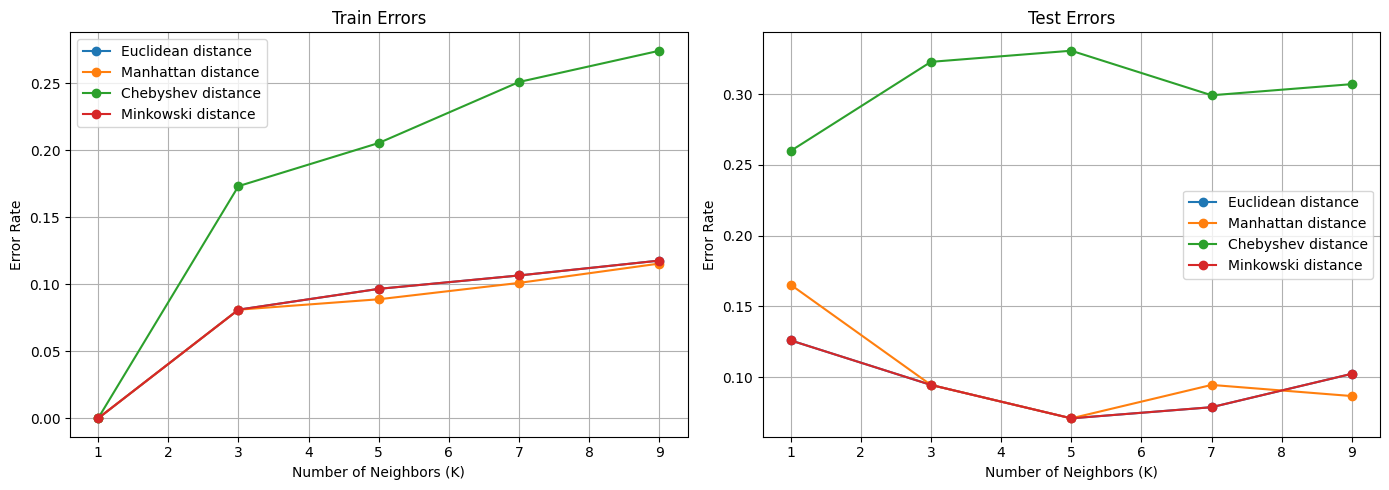

In [ ]:
# Plot train errors for each metric
plt.figure(figsize=(14, 5))

# Plot train errors for each metric
plt.subplot(1, 2, 1)
for i, metric in enumerate(metrics):
    plt.plot(K_values, train_errors[i], marker='o', label=f'{metric.capitalize()} distance')
plt.title('Train Errors')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)

# Plot test errors for each metric
plt.subplot(1, 2, 2)
for i, metric in enumerate(metrics):
    plt.plot(K_values, test_errors[i], marker='o', label=f'{metric.capitalize()} distance')
plt.title('Test Errors')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Decision Trees

In [ ]:
# Create a decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=38)

# Train the decision tree on the training data
decision_tree.fit(X_train_scaled, y_train)

# Predict labels for the test data
y_pred_tree = decision_tree.predict(X_test_scaled)

# Calculate accuracy
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print("Decision Tree Accuracy:", accuracy_tree)

Decision Tree Accuracy: 0.7874015748031497


In a Decision Tree Classifier, both Gini impurity and entropy are criteria used for splitting a node. These criteria help in determining the best feature and value to split the data at each node of the tree. Here's a brief explanation of each:
* **Gini Impurity**: Measures the probability of misclassification. Favors larger partitions and frequent classes.
* **Entropy**: Measures the level of disorder in data. Tends to create more balanced trees.


In [ ]:
# Define K values and metrics
# max_depths = [1, 30, 500, 70, 90]
criterions = ['gini', 'entropy']
num_criterions = len(criterions)

# Initialize arrays to store train error and test error for each metric and K value
train_errors = np.zeros((num_criterions))
test_errors = np.zeros((num_criterions))

# Train Decision Tree classifiers for each metric and K value
for i, criterion in enumerate(criterions):
  # Define KNN classifier with current metric and K value
  decision_tree = DecisionTreeClassifier(criterion=criterion)

  # Fit KNN classifier on the normalized training data
  decision_tree.fit(X_train_scaled, y_train)

  # Predict labels for the normalized training data
  y_train_pred = decision_tree.predict(X_train_scaled)

  # Calculate train error
  train_error = 1 - accuracy_score(y_train, y_train_pred)
  train_errors[i] = train_error

  # Predict labels for the normalized test data
  y_test_pred = decision_tree.predict(X_test_scaled)

  # Calculate test error
  test_error = 1 - accuracy_score(y_test, y_test_pred)
  test_errors[i] = test_error

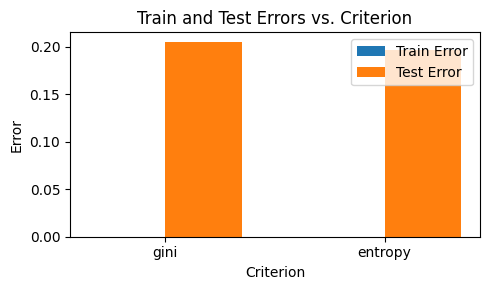

In [ ]:
# Plot the train and test errors for each criterion
plt.figure(figsize=(5, 3))
bar_width = 0.35
index = np.arange(num_criterions)

plt.bar(index, train_errors, bar_width, label='Train Error')
plt.bar(index + bar_width, test_errors, bar_width, label='Test Error')

plt.xlabel('Criterion')
plt.ylabel('Error')
plt.title('Train and Test Errors vs. Criterion')
plt.xticks(index + bar_width / 2, criterions)
plt.legend()
plt.tight_layout()
plt.show()